

*   NAME: GOUTHAM R
*   SCHOOL: CDS
*   MAIL ID: goutham.r-26@scds.saiuniversity.edu.in







In [ ]:

import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load preprocessed dataset
from numpy import load

In [ ]:

X_train_std = load('/content/drive/MyDrive/model 3/X_train_std.npy')
X_test_std = load('/content/drive/MyDrive/model 3/X_test_std.npy')
y_train = load('/content/drive/MyDrive/model 3/y_train.npy')
y_test = load('/content/drive/MyDrive/model 3/y_test.npy')

print("X_train_std shape:", X_train_std.shape)
print("X_test_std shape:", X_test_std.shape)


X_train_std shape: (1798, 224, 224, 3)
X_test_std shape: (600, 224, 224, 3)


In [ ]:
#Since I wasn't able to load the model due to layer configuration issues I rebuilt the exact same model with the already saved weights
def build_model(input_shape, num_classes):
    base_model = ConvNeXtTiny(include_top=False, weights="imagenet", input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.15)(x)  # Dropout with 15% rate
    output = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Initialize model
input_shape = (224, 224, 3)
num_classes = 5
model = build_model(input_shape, num_classes)

# Load the best weights from the Transfer Learning phase
model.load_weights("/content/drive/MyDrive/model 3/bestTL.weights.h5")
print("Successfully loaded TL weights.")


111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Successfully loaded TL weights.


In [ ]:
# Set all layers as trainable for Fine-Tuning
for layer in model.layers:
    layer.trainable = True

In [ ]:
# Compiling the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    ModelCheckpoint(
        "bestFT.weights.h5",
        monitor='val_accuracy',
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )
]

# Fine-Tune the model
history = model.fit(
    x=X_train_std,
    y=y_train,
    epochs=10,
    validation_split=0.1,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9981 - loss: 0.0213
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to bestFT.weights.h5
102/102 ━━━━━━━━━━━━━━━━━━━━ 117s 564ms/step - accuracy: 0.9981 - loss: 0.0212 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 2/10
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 2: val_accuracy did not improve from 1.00000
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 3/10
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 6.0810e-04
Epoch 3: val_accuracy did not improve from 1.00000
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 1.0000 - loss: 6.0805e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/10
101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 4.0122e-04
Epoch 4: val_accuracy did not improve from 1.00000
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step 

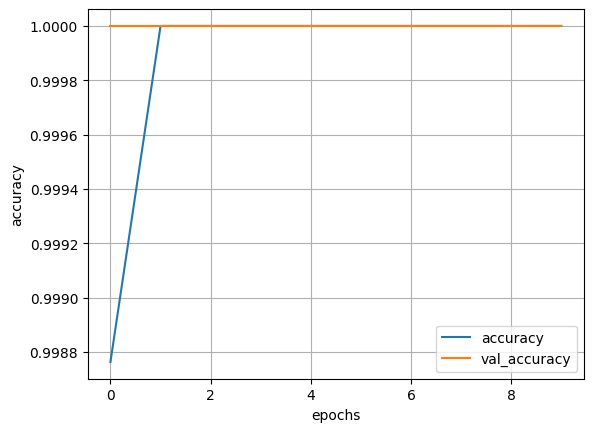

In [ ]:
#accuracy plot
keys = ['accuracy', 'val_accuracy']
progress = {k:v for k,v in history.history.items() if k in keys}

import pandas as pd
pd.DataFrame(progress).plot()

plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.grid(True)
plt.show()

In [ ]:
#model evaluation
testLoss_FineTune, testAccuracy_FineTune = model.evaluate(x = X_test_std, y = y_test)
print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FineTune, testAccuracy_FineTune))

19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 582ms/step - accuracy: 1.0000 - loss: 9.3473e-05
Test-loss: 0.000108, Test-accuracy: 1.000000


In [ ]:
#loading the model with the best weights
model.load_weights("bestFT.weights.h5")

testLoss_FineTune, testAccuracy_FineTune = model.evaluate(x = X_test_std, y = y_test)

print("Test-loss: %f, Test-accuracy: %f" % (testLoss_FineTune, testAccuracy_FineTune))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 0.0022
Test-loss: 0.002415, Test-accuracy: 1.000000


In [ ]:
y_proba = model.predict(X_test_std)
y_predict = np.argmax(y_proba, axis=-1)
print(y_predict)

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 263ms/step
[1 2 1 2 3 3 3 1 0 1 0 1 3 4 1 2 2 3 1 4 3 4 1 4 1 2 2 3 0 2 1 1 3 1 1 4 3
 1 0 0 4 0 4 4 2 4 2 1 4 3 4 1 0 4 2 0 4 1 2 0 1 2 4 3 0 0 3 2 4 2 0 3 2 2
 4 3 1 2 4 0 1 2 3 1 0 0 2 1 4 3 0 0 0 1 3 3 0 3 4 1 2 4 0 0 4 1 3 1 4 2 1
 3 1 2 2 1 2 4 2 1 2 2 4 2 3 0 4 0 2 2 2 0 4 0 2 1 3 0 0 2 3 2 0 2 2 2 1 3
 3 0 3 1 3 3 3 0 0 2 2 3 0 1 2 0 3 3 0 3 4 1 1 2 0 3 2 4 2 4 3 2 3 4 2 3 4
 1 4 2 4 0 1 1 1 1 1 1 1 4 4 0 0 4 1 4 0 2 0 4 2 1 4 2 3 4 1 4 3 3 3 4 0 4
 4 0 2 0 0 3 1 3 2 1 3 1 2 2 4 1 1 4 3 4 3 0 2 0 4 3 2 3 0 2 1 3 3 2 1 4 3
 0 0 0 0 3 2 0 2 1 0 1 4 1 2 2 3 3 4 2 0 3 1 2 4 0 1 0 1 4 4 2 1 2 4 2 1 1
 1 1 3 2 0 0 2 2 2 0 2 3 1 0 3 3 1 0 3 0 3 3 3 0 2 1 4 2 1 0 2 1 0 3 4 2 4
 0 3 2 0 3 0 4 1 2 3 0 1 2 3 2 4 1 0 4 0 4 4 0 4 1 1 3 4 2 2 3 3 0 1 2 3 1
 2 1 1 0 3 2 2 1 3 1 4 2 0 0 1 3 1 3 3 1 1 2 0 0 2 4 2 0 3 2 2 3 4 4 1 4 3
 4 3 3 0 4 2 4 4 1 2 0 2 4 3 4 1 1 2 3 2 2 3 3 2 3 3 0 1 0 0 1 4 3 2 3 3 1
 4 1 0 4 4 0 1 2 2 0 2 3 0 1 1 1 3 3 0 4 1 4 3 2 0 0 2 0 3 

In [ ]:
#precision, recall and f1-score

pScore = precision_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Precision: ", pScore)

rScore = recall_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("Recall: ", rScore)

fScore = f1_score(y_true= y_test, y_pred = y_predict, average = 'weighted')
print("F1-score: ", fScore)

print("\n\n\n")

Precision:  1.0
Recall:  1.0
F1-score:  1.0






In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y_test, y_pred = y_predict)

array([[125,   0,   0,   0,   0],
       [  0, 125,   0,   0,   0],
       [  0,   0, 125,   0,   0],
       [  0,   0,   0, 125,   0],
       [  0,   0,   0,   0, 100]])

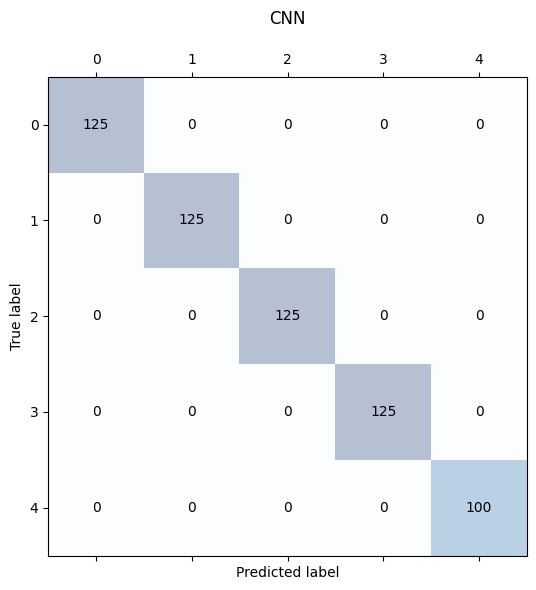

0: Damask Rose
1: Echeveria Flower
2: Mirabilis Jalapa
3: Rain Lily
4: Zinnia Elegans


In [ ]:
cm = confusion_matrix(y_true = y_test, y_pred = y_predict)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

ax.title.set_text('CNN\n')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig("ConfusionMatrix.png", dpi=300, format='png', pad_inches=0.3)
plt.show()

numbers = [0, 1, 2, 3, 4]
plants = ['Damask Rose', 'Echeveria Flower', 'Mirabilis Jalapa', 'Rain Lily', 'Zinnia Elegans']

for number, plant in zip(numbers, plants):
    print(f"{number}: {plant}")


In [ ]:

# Saves the best model obtained
model.save('/content/drive/MyDrive/Model 3/Model3ft.h5')
